# Test One for the Classical SRNN

This is a notebook for testing the classical SRNN.

## Import everything

Modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
currentPath=os.getcwd()

Import matplotlib and others

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

Import the classical SRNN and others

In [3]:
#Modify path for the notebooks
currentPath=os.path.join(currentPath,'..')
currentPath=os.path.join(currentPath,'src')
os.chdir(currentPath)

In [4]:
from DataGenerator.HenonMapDataGen import HenonMapDataGen
from QuantumModels.QuantumSRNNs import QuantumSRNN
from QuantumModels.QuantumSRNNs import QuantumSystemFunction
from GradientFreeOptimizers.CostFunc import GradFreeMSELoss
import GradientFreeOptimizers.Helpers as hp

## Test One

### Get the data

#### Set save path

In [5]:
savepath=os.path.join(currentPath,'..\data\HenonMap\Test')
filename='QuantumSRNNTest1.csv'

In [6]:
'''
hmap=HenonMapDataGen(savepath=savepath)
hmap(1000)
hmap.save_to_CSV(filename)
''';

#### Read the data

In [7]:
hmap=HenonMapDataGen(savepath=savepath)
hmap.read_from_CSV(filename)

In [8]:
print(hmap)

Data Info:
----------------------------------------
Data Size: 1000
Data Interval: 1
Data ParamA: 1.4, Data ParamB: 0.3
Data Bound: -1.2
Data HeavyMem: True
Data Seed:
 [0.0924795117387862, 0.060895690863037484]
----------------------------------------


#### Generate the data iter

In [9]:
testSetRatio=0.2
numStep=30
batchSize=1

In [10]:
trainIter,testIter=hmap.get_data_iter(testSetRatio,numStep,batchSize,mask=0,shuffle=False)

In [11]:
X,Y=next(iter(trainIter))
print('Train Data Size:',len(trainIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Train Data Size: 26
X= tensor([ 1.0288, -0.6155,  0.7783, -0.0327,  1.2320, -1.1348, -0.4332,  0.3969,
         0.6495,  0.5284,  0.8039,  0.2538,  1.1510, -0.7786,  0.4966,  0.4212,
         0.9006, -0.0091,  1.2701, -1.2610, -0.8451, -0.3780,  0.5464,  0.4686,
         0.8565,  0.1136,  1.2389, -1.1147, -0.3678,  0.4763])
Y= tensor([-0.6155,  0.7783, -0.0327,  1.2320, -1.1348, -0.4332,  0.3969,  0.6495,
         0.5284,  0.8039,  0.2538,  1.1510, -0.7786,  0.4966,  0.4212,  0.9006,
        -0.0091,  1.2701, -1.2610, -0.8451, -0.3780,  0.5464,  0.4686,  0.8565,
         0.1136,  1.2389, -1.1147, -0.3678,  0.4763,  0.5721])


In [12]:
X,Y=next(iter(testIter))
print('Test Data Size:',len(testIter))
print('X=',torch.squeeze(X))
print('Y=',torch.squeeze(Y))

Test Data Size: 5
X= tensor([ 0.8114,  0.2343,  1.1665, -0.8348,  0.3742,  0.5535,  0.6834,  0.5122,
         0.8378,  0.1710,  1.2104, -0.9999, -0.0365,  0.6982,  0.3066,  1.0778,
        -0.5344,  0.9235, -0.3543,  1.1013, -0.8044,  0.4246,  0.5063,  0.7684,
         0.3252,  1.0825, -0.5429,  0.9121, -0.3276,  1.1234])
Y= tensor([ 0.2343,  1.1665, -0.8348,  0.3742,  0.5535,  0.6834,  0.5122,  0.8378,
         0.1710,  1.2104, -0.9999, -0.0365,  0.6982,  0.3066,  1.0778, -0.5344,
         0.9235, -0.3543,  1.1013, -0.8044,  0.4246,  0.5063,  0.7684,  0.3252,
         1.0825, -0.5429,  0.9121, -0.3276,  1.1234, -0.8650])


### Define the SRNN

#### Parameters

In [13]:
inputSize=outputSize=1
qubits=4

In [14]:
activation=[0,2]
inputQubits=outputQubits=[i for i in range(qubits)]
interQPairs=[[i,j] for i in range(qubits) for j in range(i+1,qubits)]
inactive=['WIn','DeltaIn','J']
print('Input Qubits:',inputQubits)
print('Output Qubits:',outputQubits)
print('InterQPairs=',interQPairs)

Input Qubits: [0, 1, 2, 3]
Output Qubits: [0, 1, 2, 3]
InterQPairs= [[0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3]]


In [15]:
measEffect=True

#### Get neccesary functions

In [16]:
srnnTestSup=QuantumSystemFunction()

In [17]:
transform=lambda Xs:[torch.squeeze(x) for x in Xs]

In [18]:
init_rnn_state=srnnTestSup.get_init_state_fun(activation=activation)
get_params=srnnTestSup.get_get_params_fun(inputQubits=inputQubits,outputQubits=outputQubits,interQPairs=interQPairs,inactive=inactive)
rnn=srnnTestSup.get_forward_fn_fun(measEffect=measEffect)
predict_fun=srnnTestSup.get_predict_fun(outputTransoform=transform)

#### Create the SRNN

In [19]:
net=QuantumSRNN(inputSize,qubits,outputSize,get_params,init_rnn_state,rnn)

#### Test prediction

In [18]:
state=net.begin_state(batchSize)
Y,newState=net(X,state)
Y.shape, len(newState), newState[0].shape

(torch.Size([40, 1]), 1, torch.Size([4, 6]))

In [19]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[:2],-1),torch.unsqueeze(preY[:10],-1)
print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
print('preY=',preY)

preX= tensor([[0.0041],
        [0.0660]])
preY= [tensor([0.0041]), tensor([0.0660]), tensor([0.9951]), tensor([-0.3666]), tensor([1.1104]), tensor([-0.8361]), tensor([0.3545]), tensor([0.5733]), tensor([0.6463]), tensor([0.5872]), tensor([0.7111])]


In [20]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=5)
print('YHat=',YHat)

YHat= [tensor(0.0041), tensor(0.0660), tensor(1.2776e-05), tensor(3.4233e-07), tensor(-1.9828e-08), tensor(5.4997e-10), tensor(-1.1543e-11)]


### Train the network

#### Parameters

In [21]:
num_epochs, lr = 600, 0.1

#### Loss function

In [22]:
lossFunc=GradFreeMSELoss(net)

#### Trainer

In [23]:
trainer = torch.optim.SGD(net.params, lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(trainer,step_size=100,gamma=0.1)

#### Initial loss

In [24]:
l_epochs=[]
train_l=SuportFunction.evaluate_accuracy(net,trainIter,lossFunc,False)
test_l=SuportFunction.evaluate_accuracy(net,testIter,lossFunc,False)
l_epochs.append([train_l,test_l])
print('Initial Train Loss:',train_l)
print('Initial Test Loss:',test_l)

Initial Train Loss: 0.5854037797630732
Initial Test Loss: 0.5828977661132813


#### Training

TestLoss 0.000341, 13503.679743 point/s
Prediction:
 [tensor(0.0041), tensor(0.0660), tensor(0.9567), tensor(-0.2716), tensor(1.1833), tensor(-1.0393), tensor(-0.1756), tensor(0.6417), tensor(0.3719), tensor(0.9985), tensor(-0.2967)]
Answer:
 [tensor([0.0041]), tensor([0.0660]), tensor([0.9951]), tensor([-0.3666]), tensor([1.1104]), tensor([-0.8361]), tensor([0.3545]), tensor([0.5733]), tensor([0.6463]), tensor([0.5872]), tensor([0.7111])]


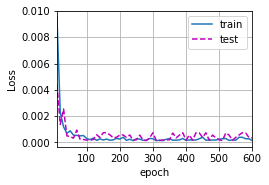

In [25]:
animator = hp.Animator(xlabel='epoch', ylabel='Loss',
                            legend=['train','test'], xlim=[10, num_epochs])
    # prediction
predict = lambda prefix: predict_fun(prefix,net, numPreds=9)
# train and predict
for epoch in range(num_epochs):
    trainLoss, speed = SuportFunction.train_epoch(
        net, trainIter, lossFunc, trainer, False)
    testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
    if (epoch + 1) % 10 == 0:
        print(predict(preX))
        animator.add(epoch + 1, [trainLoss,testLoss])
    l_epochs.append([trainLoss,testLoss])
    scheduler.step()
testLoss=SuportFunction.evaluate_accuracy(net, testIter, lossFunc, False)
print(f'TestLoss {testLoss:f}, {speed:f} point/s')
print('Prediction:\n',predict(preX))
print('Answer:\n',preY)

### Visualize the performance

#### One Step Prediction

In [26]:
X,Y=next(iter(testIter))
state=net.begin_state(batchSize)
Y_hat,newState=net(X,state)
print('X=',torch.squeeze(X))
print('Prediction=',torch.squeeze(Y_hat).detach())
Y=Y.transpose(0,1).reshape([-1,Y.shape[-1]])
print('Y=',torch.squeeze(Y))



X= tensor([[ 0.9933, -0.5261,  0.9106, -0.3186,  1.1310, -0.8866,  0.2390,  0.6541,
          0.4727,  0.8834],
        [ 0.7001,  0.4921,  0.8710,  0.0856,  1.2510, -1.1655, -0.5263,  0.2626,
          0.7456,  0.3006],
        [-0.5627,  0.8829, -0.2601,  1.1701, -0.9949, -0.0348,  0.6998,  0.3039,
          1.0807, -0.5438],
        [ 1.2313, -1.1317, -0.4238,  0.4090,  0.6386,  0.5517,  0.7654,  0.3454,
          1.0626, -0.4773]])
Prediction= tensor([-0.3704,  0.3911,  0.2183, -1.0951,  0.9367,  0.9153, -0.3851, -0.5020,
        -0.3308,  0.0810,  1.1839,  0.4064,  1.1355,  1.2372, -0.9990,  0.6409,
        -0.8948, -1.1507, -0.0499,  0.5592,  0.2371, -0.5406,  0.6937,  0.7791,
         0.6547,  0.2678,  0.3010,  0.3555,  0.4724,  0.7395,  1.0768,  1.0614,
         0.8930,  0.3017, -0.5607, -0.4954,  0.0485,  1.0940,  0.9190,  1.0064])
Y= tensor([-0.5261,  0.4921,  0.8829, -1.1317,  0.9106,  0.8710, -0.2601, -0.4238,
        -0.3186,  0.0856,  1.1701,  0.4090,  1.1310,  1.2510, -0

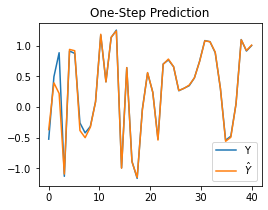

In [27]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('One-Step Prediction')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y),label='Y')
plt.plot(torch.linspace(0,Y.numel(),Y.numel()),torch.squeeze(Y_hat).detach(),label=r'$\hat{Y}$')
plt.legend();

#### Multi Step Prediction

In [28]:
prefixSize=10
totalSize=40
testShift=int(len(hmap)*(1-testSetRatio))

In [29]:
preX,preY=hmap.data_as_tensor
preX,preY=torch.unsqueeze(preX[testShift:testShift+prefixSize],-1),torch.unsqueeze(preY[testShift:testShift+totalSize-1],-1)
#print('preX=',preX)
preY=[y for y in torch.cat((preX[:2],preY[1:]),dim=0)]
#print('preY=',preY)
len(preY)

40

In [30]:
preX=torch.unsqueeze(preX,-1)
YHat=predict_fun(preX,net,numPreds=totalSize-prefixSize)
#print('YHat=',YHat)
len(YHat)

40

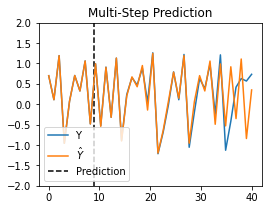

In [31]:
#Visualize the data
axes,fig=plt.subplots(1,1,figsize=(4,3))
plt.title('Multi-Step Prediction')
fig.set_ylim(-2,2)
plt.plot(torch.linspace(0,len(preY),len(preY)),preY,label='Y')
plt.plot(torch.linspace(0,len(preY),len(preY)),YHat,label=r'$\hat{Y}$')
plt.vlines([prefixSize-1],ymin=-2,ymax=2,linestyles='dashed',label='Prediction')
plt.legend();

# End of the test